### Cosc2671 Assignment 2 Group 15 


In [1]:
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import nltk
import praw
import datetime as dt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Initialize tools
tokenizer = TweetTokenizer()
tokenizer = TweetTokenizer(preserve_case=False)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [3]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    #Remove non-alphabetic characters but keep @, #, and apostrophe
    text = re.sub(r'[^a-zA-Z@\s#\']', '', text)
    #Tokenize
    tokens = tokenizer.tokenize(text)
    #Remove stopwords and short tokens; lemmatize
    cleaned = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return cleaned

In [4]:
#Reddit API credentials
clientid = "FgY4iejqu83Q9QpgNMX9dQ"
clientsecret = "eeSZYZUjfMIAQ5qcULOc9SSYOHghFQ"
password = "1357900jkx"
username = "Traditional-Shine402"
useragents = 'client for SNAM2024'
reddit = praw.Reddit(client_id=clientid, client_secret=clientsecret,password=password,
                           username=username,user_agent=useragents)


#Keywords and Subreddits
keywords = [
    "moon landing fake", 
    "moon landing hoax", 
    "fake moon landing", 
    "did we land on the moon", 
    "moon landing conspiracy", 
    "moon landing was staged", 
    "apollo mission fake", 
    "moon landing faked", 
    "moon hoax", 
    "apollo hoax", 
    "moon conspiracy", 
    "moon landing lies", 
    "nasa faked moon landing"]

subreddits = ["conspiracy", "moonlandingfake"]


In [5]:
#Data collection
posts = []

for subreddit in subreddits:
    for keyword in keywords:
        for submission in reddit.subreddit(subreddit).search(keyword, limit=10000):
            posts.append({
                'subreddit': subreddit,
                'title': submission.title.lower(),
                'text': submission.selftext.lower(),
                'author': str(submission.author),
                'score': submission.score,
                'created_utc': dt.datetime.fromtimestamp(submission.created_utc),
                'id': submission.id,
                'num_comments': submission.num_comments
            })

posts_df = pd.DataFrame(posts)
print(f"Fetched {len(posts_df)} posts.")
# Fetch comments
comments_data = []

for post_id in posts_df['id']:
    if len(comments_data) > 25000:
        break
    submission = reddit.submission(id=post_id)
    submission.comments.replace_more(limit=0)
    for comment in submission.comments.list():
        comments_data.append({
            'post_id': post_id,
            'comment_id': comment.id,
            'comment_body': comment.body.lower(),
            'author': str(comment.author),
            "parent_id": comment.parent_id,
            'parent_type': comment.parent_id[:2],# Can be t1_xxxx (comment) or t3_xxxx (submission)
            'score': comment.score,
            'created_utc': dt.datetime.fromtimestamp(comment.created_utc)
        })

comments_df = pd.DataFrame(comments_data)
comments_df['cleaned_tokens'] = comments_df['comment_body'].astype(str).apply(preprocess_text)
comments_df.to_csv("reddit_comments.csv", index=False)
print(f"Fetched {len(comments_df)} comments.")

Fetched 2847 posts.
Fetched 25068 comments.


In [6]:
posts_df['all_text'] = posts_df['title'] + " " + posts_df['text']
posts_df['cleaned_tokens'] = posts_df['all_text'].astype(str).apply(preprocess_text)
posts_df.to_csv("reddit_posts.csv", index=False)

In [7]:
posts_df

subreddit                                              title  \
0          conspiracy                     did we ever land on the moon…?   
1          conspiracy  can you tell me why you think the moon landing...   
2          conspiracy  if the moon landing was fake, why the enemies ...   
3          conspiracy  why do people get so defensive when the 1969 m...   
4          conspiracy  if the moon landing was faked how have other c...   
...               ...                                                ...   
2842  moonlandingfake  why i no longer believe the apollo moon landin...   
2843  moonlandingfake                                   here's the truth   
2844  moonlandingfake                                               bruh   
2845  moonlandingfake  is it me or has the internet become the most e...   
2846  moonlandingfake                                          the proof   

                                                   text               author  \
0                                                            Own_Teacher3433   
1     i come in peace! i am a about to start my phd ...            Ms_Photon   
2                                                                 TimmyOTule   
3     whenever a moon landing conspiracy is posted t...        Majin_Vegeta_   
4     in my limited understanding of space travel, w...               5afari   
...                                                 ...                  ...   
2842                                                         HelicopterJesus   
2843             moon landings were faked on the moon.💀        Sea-Mark-7504   
2844  i've gotten 50 new types of brain cancer from ...  YesterdayDirect8401   
2845  i used to use it to win all kinds of arguments...    ElectronicPresenc   
2846  i wanted to ask, if i provide help to recreate...        Mradul_Sharma   

      score         created_utc       id  num_comments  \
0       737 2024-08-23 22:28:45  1ezbh2v           759   
1       866 2023-03-12 01:48:43  11olzpd          1374   
2       190 2024-09-27 22:26:50  1fqmhry           527   
3       252 2024-01-03 10:27:29  18x3uai           449   
4       386 2022-07-13 22:57:31   vy2lws           525   
...     ...                 ...      ...           ...   
2842      5 2021-10-27 04:31:21   qgbkci             1   
2843     12 2023-03-04 04:55:36  11h8s9e             5   
2844     20 2022-11-26 00:36:44   z4dkp6             6   
2845     12 2022-09-21 16:45:45   xjxct3             7   
2846      3 2022-07-14 17:55:04   vyqdi1             3   

                                               all_text  \
0                       did we ever land on the moon…?    
1     can you tell me why you think the moon landing...   
2     if the moon landing was fake, why the enemies ...   
3     why do people get so defensive when the 1969 m...   
4     if the moon landing was faked how have other c...   
...                                                 ...   
2842  why i no longer believe the apollo moon landin...   
2843  here's the truth moon landings were faked on t...   
2844  bruh i've gotten 50 new types of brain cancer ...   
2845  is it me or has the internet become the most e...   
2846  the proof i wanted to ask, if i provide help t...   

                                         cleaned_tokens  
0                                    [ever, land, moon]  
1     [tell, think, moon, landing, fake, might, conv...  
2                [moon, landing, fake, enemy, revealed]  
3     [people, get, defensive, moon, landing, questi...  
4     [moon, landing, faked, country, debunked, yet,...  
...                                                 ...  
2842  [longer, believe, apollo, moon, landing, faked...  
2843        [here's, truth, moon, landing, faked, moon]  
2844  [bruh, gotten, new, type, brain, cancer, came,...  
2845  [internet, become, efficient, disinformation, ...  
2846  [proof, wanted, ask, provide, help, recreate, ...  

[2847 rows x 10 columns]

In [8]:
comments_df

post_id comment_id                                       comment_body  \
0      1ezbh2v    ljjajn3  ###[meta] sticky comment\n\n[rule 2](https://w...   
1      1ezbh2v    ljk3dzz  i once asked a.i how to get sugar out of a gas...   
2      1ezbh2v    ljkwr8b  everyone loves ai when it gives you the answer...   
3      1ezbh2v    ljjib43     wow that ai has such an unbiased sounding name   
4      1ezbh2v    ljk3hf2  i don't know, but china confirmed their probes...   
...        ...        ...                                                ...   
25063   inv7sf    g4ai960  you're wildly miss interpreting the different ...   
25064   inv7sf    g4asyle                                          [removed]   
25065   inv7sf    g4alcbl                                 oh i will, thanks!   
25066   inv7sf    g4ebr5j         i got down voted also. people are so dense   
25067   inv7sf    g4av3tl                                             rule 2   

                     author   parent_id parent_type  score  \
0             AutoModerator  t3_1ezbh2v          t3      1   
1                 dinahmoon  t3_1ezbh2v          t3    801   
2              Binarydemons  t3_1ezbh2v          t3    160   
3           before686entenz  t3_1ezbh2v          t3    646   
4      AccordingWarning9534  t3_1ezbh2v          t3    319   
...                     ...         ...         ...    ...   
25063                 Voia-  t1_g4afybx          t1      1   
25064                  None  t1_g4ar7e0          t1      1   
25065         AWildSlowpoke  t1_g4akszf          t1      1   
25066                 Voia-  t1_g4annuj          t1      1   
25067             Sabremesh  t1_g4asyle          t1      1   

              created_utc                                     cleaned_tokens  
0     2024-08-23 22:28:47  [###meta, sticky, comment, rule, apply, replyi...  
1     2024-08-24 01:15:41  [asked, get, sugar, gas, tank, told, use, stra...  
2     2024-08-24 03:49:59         [everyone, love, give, answer, want, hear]  
3     2024-08-23 23:18:37                    [wow, unbiased, sounding, name]  
4     2024-08-24 01:16:11  [know, china, confirmed, probe, moon, rover, s...  
...                   ...                                                ...  
25063 2020-09-07 12:03:57  [wildly, miss, interpreting, different, type, ...  
25064 2020-09-07 14:00:38                                          [removed]  
25065 2020-09-07 12:35:29                                           [thanks]  
25066 2020-09-08 11:07:13                  [got, voted, also, people, dense]  
25067 2020-09-07 14:27:17                                             [rule]  

[25068 rows x 9 columns]

### Start code from here!

In [9]:
posts_df = pd.read_csv("reddit_posts.csv")
comments_df = pd.read_csv("reddit_comments.csv")

In [10]:
print(posts_df.isnull().sum())

subreddit           0
title               0
text              911
author              0
score               0
created_utc         0
id                  0
num_comments        0
all_text            0
cleaned_tokens      0
dtype: int64


In [11]:
import ast
# Convert strings that look like lists into real lists
posts_df['cleaned_tokens'] = posts_df['cleaned_tokens'].apply(ast.literal_eval)
comments_df['cleaned_tokens'] = comments_df['cleaned_tokens'].apply(ast.literal_eval)
# Now flatten
all_post_tokens = [token for tokens in posts_df['cleaned_tokens'] for token in tokens]
all_comments_tokens = [token for tokens in comments_df['cleaned_tokens'] for token in tokens]

In [12]:
#Combine all tokens
all_tokens = all_post_tokens + all_comments_tokens

In [13]:
print("Total tokens: ", len(all_tokens))
unique_tokens = len(set(all_tokens))
print("Unique tokens: ", unique_tokens)

Total tokens:  1165120
Unique tokens:  36492


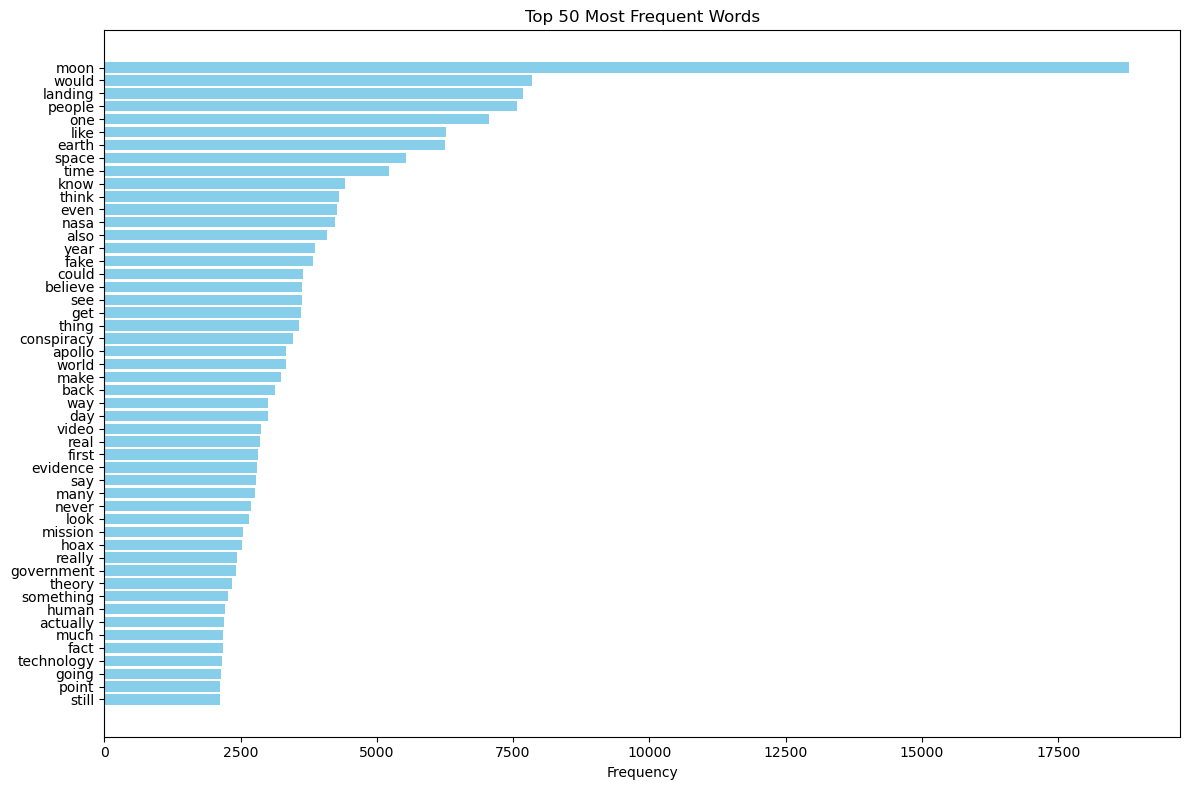

In [14]:
from collections import Counter

token_freq = Counter(all_tokens)
#Get the top 50 most common words
top_words = Counter(all_tokens).most_common(50)

#Separate the words and their counts
words, counts = zip(*top_words)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(words[::-1], counts[::-1], color='skyblue')  # reverse to have highest on top
plt.xlabel("Frequency")
plt.title("Top 50 Most Frequent Words")
plt.tight_layout()
plt.show()

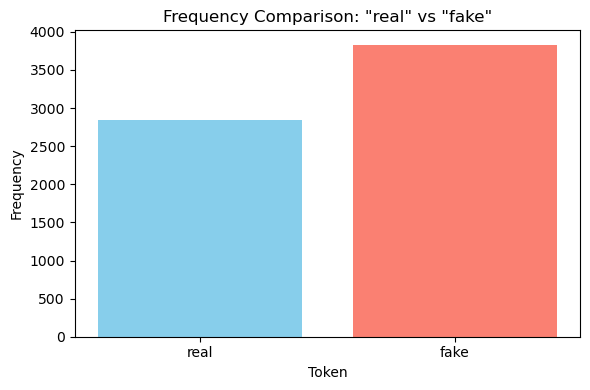

In [15]:
# Get frequencies (default to 0 if not found)
real_freq = Counter(all_tokens).get('real', 0)
fake_freq = Counter(all_tokens).get('fake', 0)

# Create bar chart
plt.figure(figsize=(6, 4))
plt.bar(['real', 'fake'], [real_freq, fake_freq], color=['skyblue', 'salmon'])
plt.title('Frequency Comparison: "real" vs "fake"')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Sentiment Analysis

In [16]:
#Rename posts tokens column
posts_df.rename(columns={'cleaned_tokens': 'cleaned_tokens_post'}, inplace=True)

#Rename comments tokens column if needed
comments_df.rename(columns={'cleaned_tokens': 'cleaned_tokens_comments'}, inplace=True)


In [17]:
#Create a dictionary to hold post_id
comment_token_map = {}

for i in range(len(comments_df)):
    post_id = comments_df.loc[i, 'post_id']
    tokens = comments_df.loc[i, 'cleaned_tokens_comments']
    
    if post_id not in comment_token_map:
        comment_token_map[post_id] = []
    
    comment_token_map[post_id].extend(tokens)

#Prepare a list to hold the final combined tokens
combined_data = []

for i in range(len(posts_df)):
    post_id = posts_df.loc[i, 'id']
    post_tokens = posts_df.loc[i, 'cleaned_tokens_post']
    comment_tokens = comment_token_map.get(post_id, [])
    subreddit = posts_df.loc[i,'subreddit']
    
    all_tokens = post_tokens + comment_tokens
    combined_data.append({'post_id': post_id, 'subreddit': subreddit, 'all_tokens': all_tokens})

combined_tokens_df = pd.DataFrame(combined_data)


In [18]:
combined_tokens_df

post_id        subreddit  \
0     1ezbh2v       conspiracy   
1     11olzpd       conspiracy   
2     1fqmhry       conspiracy   
3     18x3uai       conspiracy   
4      vy2lws       conspiracy   
...       ...              ...   
2842   qgbkci  moonlandingfake   
2843  11h8s9e  moonlandingfake   
2844   z4dkp6  moonlandingfake   
2845   xjxct3  moonlandingfake   
2846   vyqdi1  moonlandingfake   

                                             all_tokens  
0     [ever, land, moon, ###meta, sticky, comment, r...  
1     [tell, think, moon, landing, fake, might, conv...  
2     [moon, landing, fake, enemy, revealed, ###meta...  
3     [people, get, defensive, moon, landing, questi...  
4     [moon, landing, faked, country, debunked, yet,...  
...                                                 ...  
2842  [longer, believe, apollo, moon, landing, faked...  
2843        [here's, truth, moon, landing, faked, moon]  
2844  [bruh, gotten, new, type, brain, cancer, came,...  
2845  [internet, become, efficient, disinformation, ...  
2846  [proof, wanted, ask, provide, help, recreate, ...  

[2847 rows x 3 columns]

In [19]:
sia = SentimentIntensityAnalyzer()

#get compound sentiment score tokens = tokens from reddit posts
def get_sentiment(tokens):
    text = ' '.join(tokens)
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

#Apply sentiment score function to the DataFrame
combined_tokens_df['sentiment'] = combined_tokens_df['all_tokens'].apply(get_sentiment)


In [20]:
combined_tokens_df

post_id        subreddit  \
0     1ezbh2v       conspiracy   
1     11olzpd       conspiracy   
2     1fqmhry       conspiracy   
3     18x3uai       conspiracy   
4      vy2lws       conspiracy   
...       ...              ...   
2842   qgbkci  moonlandingfake   
2843  11h8s9e  moonlandingfake   
2844   z4dkp6  moonlandingfake   
2845   xjxct3  moonlandingfake   
2846   vyqdi1  moonlandingfake   

                                             all_tokens  sentiment  
0     [ever, land, moon, ###meta, sticky, comment, r...     0.9997  
1     [tell, think, moon, landing, fake, might, conv...     0.9997  
2     [moon, landing, fake, enemy, revealed, ###meta...    -0.8991  
3     [people, get, defensive, moon, landing, questi...     0.9956  
4     [moon, landing, faked, country, debunked, yet,...    -0.9801  
...                                                 ...        ...  
2842  [longer, believe, apollo, moon, landing, faked...     0.0000  
2843        [here's, truth, moon, landing, faked, moon]     0.3182  
2844  [bruh, gotten, new, type, brain, cancer, came,...     0.1280  
2845  [internet, become, efficient, disinformation, ...    -0.9438  
2846  [proof, wanted, ask, provide, help, recreate, ...     0.8885  

[2847 rows x 4 columns]

In [21]:
#Group by subreddit
sentiment_by_subreddit = combined_tokens_df.groupby('subreddit')['sentiment'].mean().sort_values()


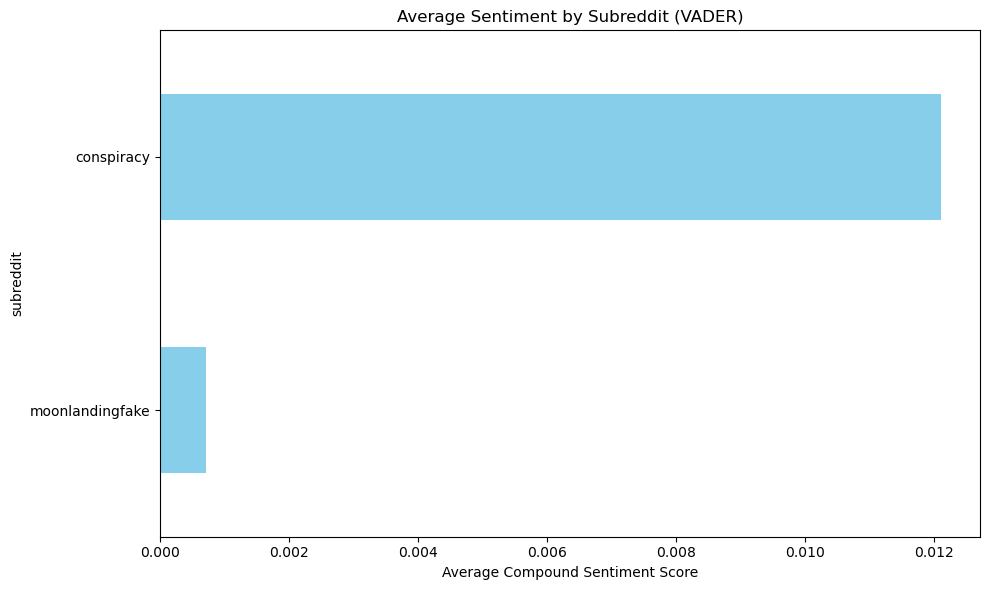

In [22]:
# Plotting
plt.figure(figsize=(10, 6))
sentiment_by_subreddit.plot(kind='barh', color='skyblue')
plt.xlabel('Average Compound Sentiment Score')
plt.title('Average Sentiment by Subreddit (VADER)')
plt.tight_layout()
plt.show()


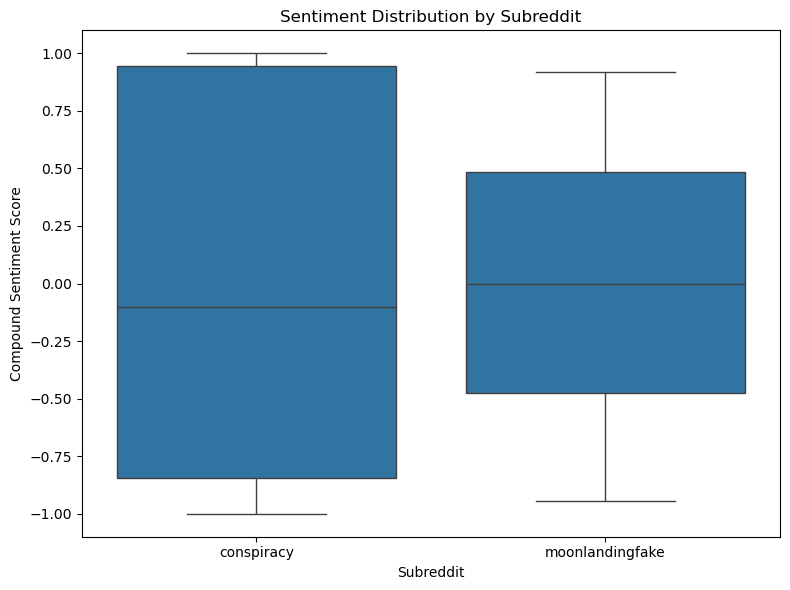

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='subreddit', y='sentiment', data=combined_tokens_df)
plt.title('Sentiment Distribution by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Compound Sentiment Score')
plt.tight_layout()
plt.show()

In [24]:
def count_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= 0.05:
        return 'Negative'
    else:
        return 'Neutral'


In [25]:
combined_tokens_df['sentiment_label'] = combined_tokens_df['sentiment'].apply(count_sentiment)

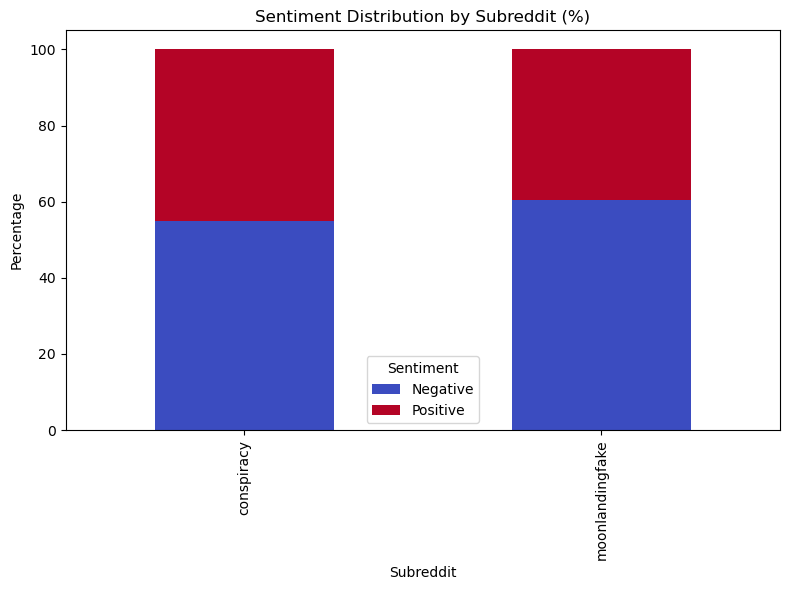

In [26]:
# Count sentiment categories per subreddit
sentiment_counts = combined_tokens_df.groupby(['subreddit', 'sentiment_label']).size().unstack().fillna(0)

# Normalize and convert to percentages
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
sentiment_percentages.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='coolwarm')
plt.title('Sentiment Distribution by Subreddit (%)')
plt.ylabel('Percentage')
plt.xlabel('Subreddit')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


In [27]:
sentiment_counts

sentiment_label  Negative  Positive
subreddit                          
conspiracy           1467      1206
moonlandingfake       105        69

### Topic Modelling

In [28]:
#Group by subreddit into a dictionary
grouped_tokens = (
    combined_tokens_df.groupby('subreddit')['all_tokens']
    .apply(lambda token_lists: [' '.join(tokens) for tokens in token_lists])
    .to_dict()
)

In [29]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import math

#Get the LDA topics

def get_lda_topics(docs, num_topics=5, num_words=15):
    vectorizer = CountVectorizer(max_df=0.85, min_df=1, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(docs)

    lda_model = LDA(n_components=num_topics, random_state=42)
    lda_model.fit(doc_term_matrix)

    feature_names = vectorizer.get_feature_names_out()
    
    topics = []
    for topic in lda_model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topics.append(top_words)
    
    return lda_model, feature_names, topics

In [30]:
def display_wordcloud(lda_model, feature_names, topic_idx=0):
    topic = lda_model.components_[topic_idx]
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-16:-1]}
    
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(topic_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()


 Subreddit: conspiracy


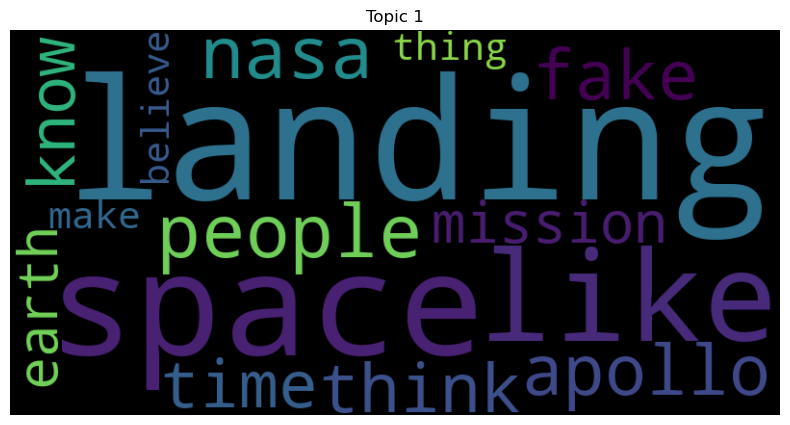

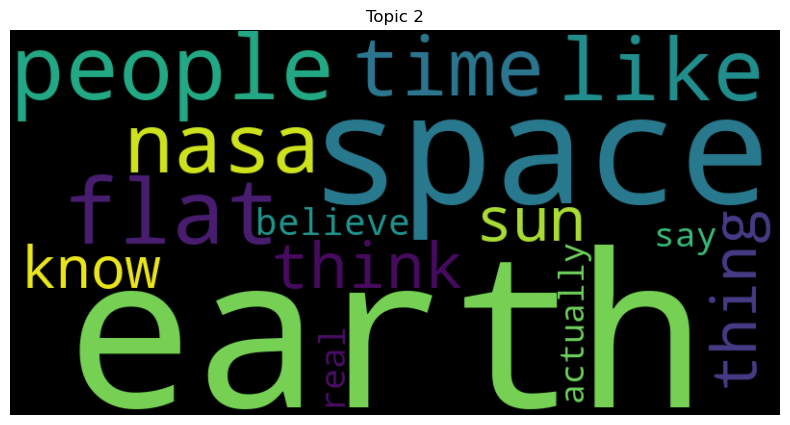

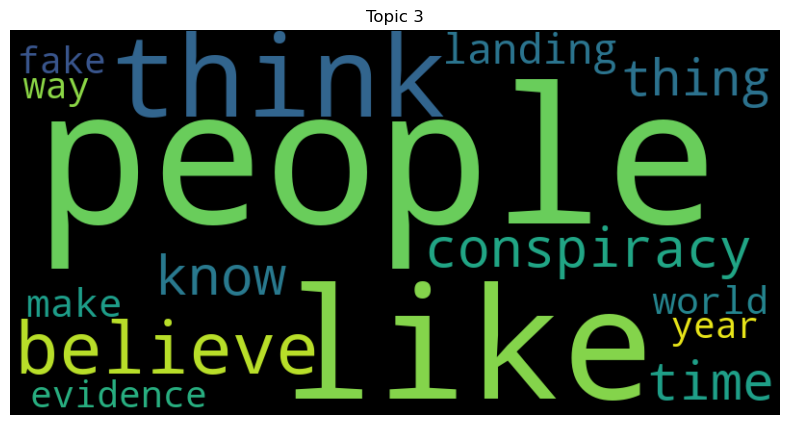

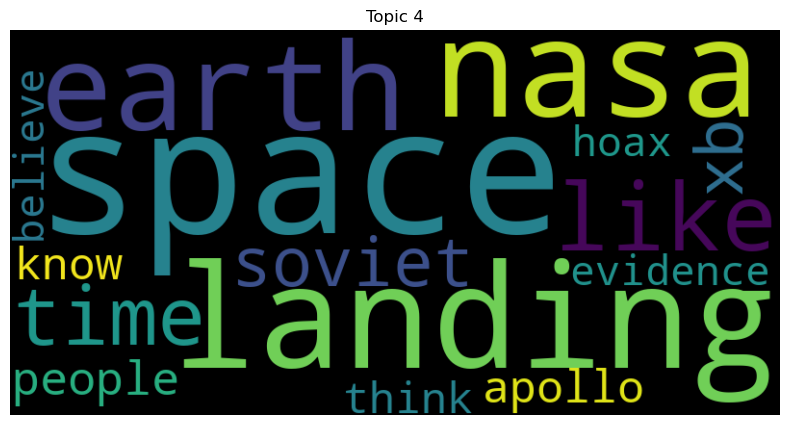

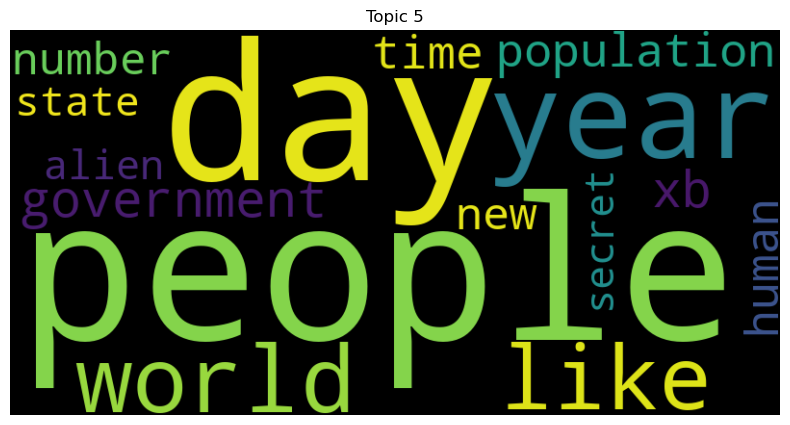


 Subreddit: moonlandingfake


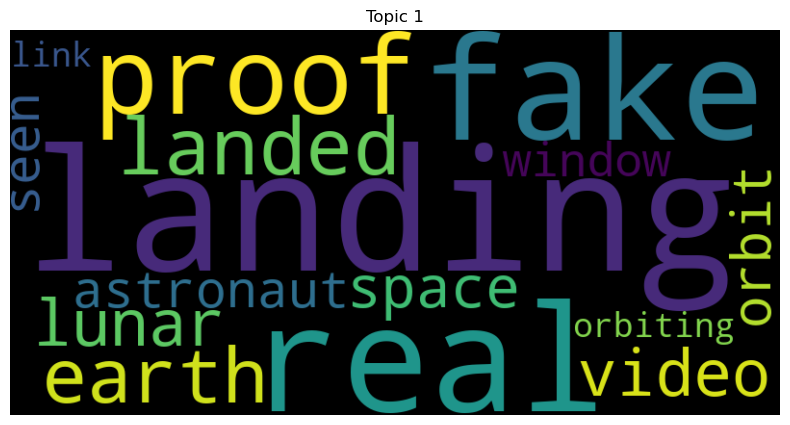

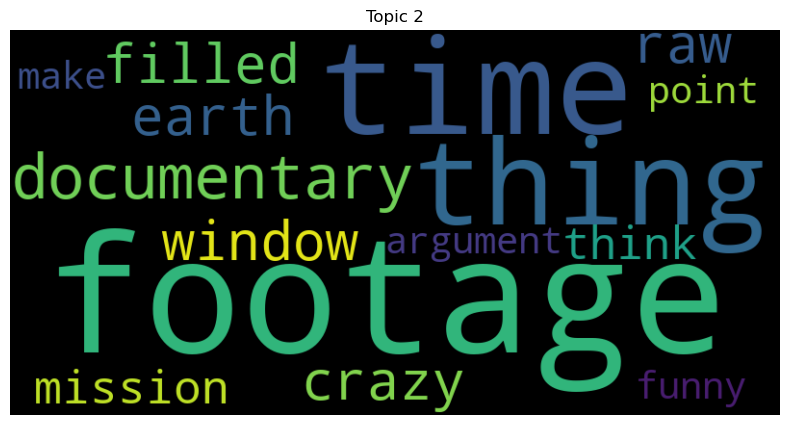

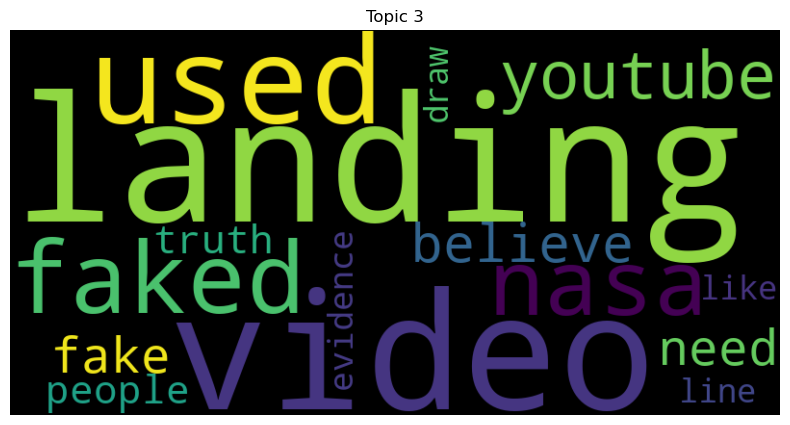

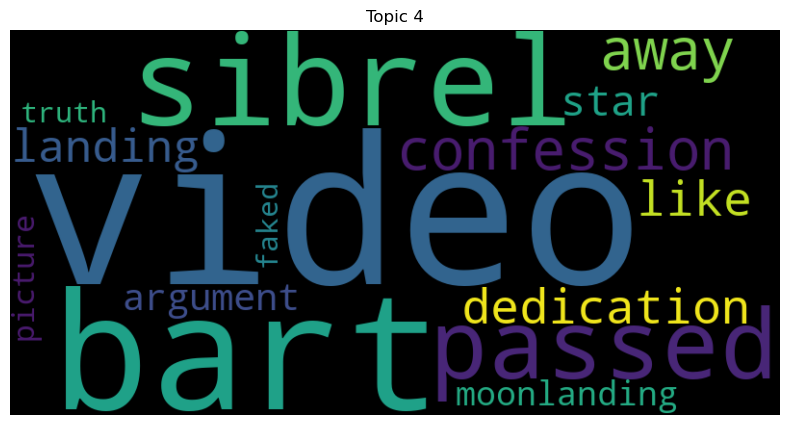

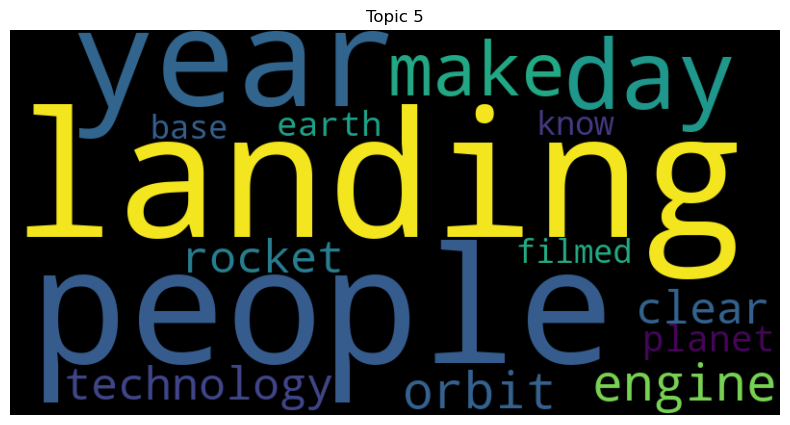

In [31]:
for subreddit, docs in grouped_tokens.items():
    if len(docs) > 1:
        print(f"\n Subreddit: {subreddit}")
        lda_model, feature_names, topics = get_lda_topics(docs, num_topics=5, num_words=15)
        for i, topic_words in enumerate(topics):
            display_wordcloud(lda_model, feature_names, topic_idx=i)

### Network Analysis

In [32]:
import networkx as nx
from community import community_louvain

In [33]:
#Drop comments where author is '[deleted]' or None
comments_df = comments_df[comments_df['author'].notnull()]
comments_df = comments_df[comments_df['author'] != '[deleted]']

#Create a lookup dictionary: comment_id -> author
comment_author_lookup = dict(zip(comments_df['comment_id'], comments_df['author']))

#Building edges
edges = []

for _, row in comments_df.iterrows():
    if row['parent_type'] == 't1':  # replied to another comment
        parent_comment_id = row['parent_id'].split('_')[1]  # remove 't1_'
        replier = row['author']
        parent_author = comment_author_lookup.get(parent_comment_id)

        #Only add edge if parent author exists and isn't the same as replier
        if parent_author and parent_author != replier:
            edges.append((replier, parent_author))


In [34]:
#Create the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Optionally, remove self-loops (user replying to themselves)
G.remove_edges_from(nx.selfloop_edges(G))

# Export to GraphML
nx.write_graphml(G, "reddit_reply_network.graphml")

print(f"Graph exported with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph exported with 4810 nodes and 8435 edges.


In [35]:
#Top users by number of replies received (in-degree)
top_replied_to = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
print("Top users by replies received:")
for user, degree in top_replied_to:
    print(f"{user}: {degree} replies")

#Top users by replies made (out-degree)
top_repliers = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop users by replies made:")
for user, degree in top_repliers:
    print(f"{user}: {degree} replies made")


Top users by replies received:
Kazeite: 97 replies
EnoughNoLibsSpam: 88 replies
uphillbothwaysnoshoe: 73 replies
CarbonSlayer72: 39 replies
TreyinHada: 34 replies
joe_jaywalker: 32 replies
4544BeersOnTheWall: 30 replies
Hot_Acadia9758: 28 replies
Noel2Joel: 24 replies
Blitzer046: 23 replies

Top users by replies made:
Kazeite: 211 replies made
uphillbothwaysnoshoe: 120 replies made
EnoughNoLibsSpam: 108 replies made
4544BeersOnTheWall: 59 replies made
SgtBrutalisk: 52 replies made
Darkherring1: 45 replies made
CarbonSlayer72: 42 replies made
Blitzer046: 41 replies made
bumbacorn: 38 replies made
joe_jaywalker: 36 replies made


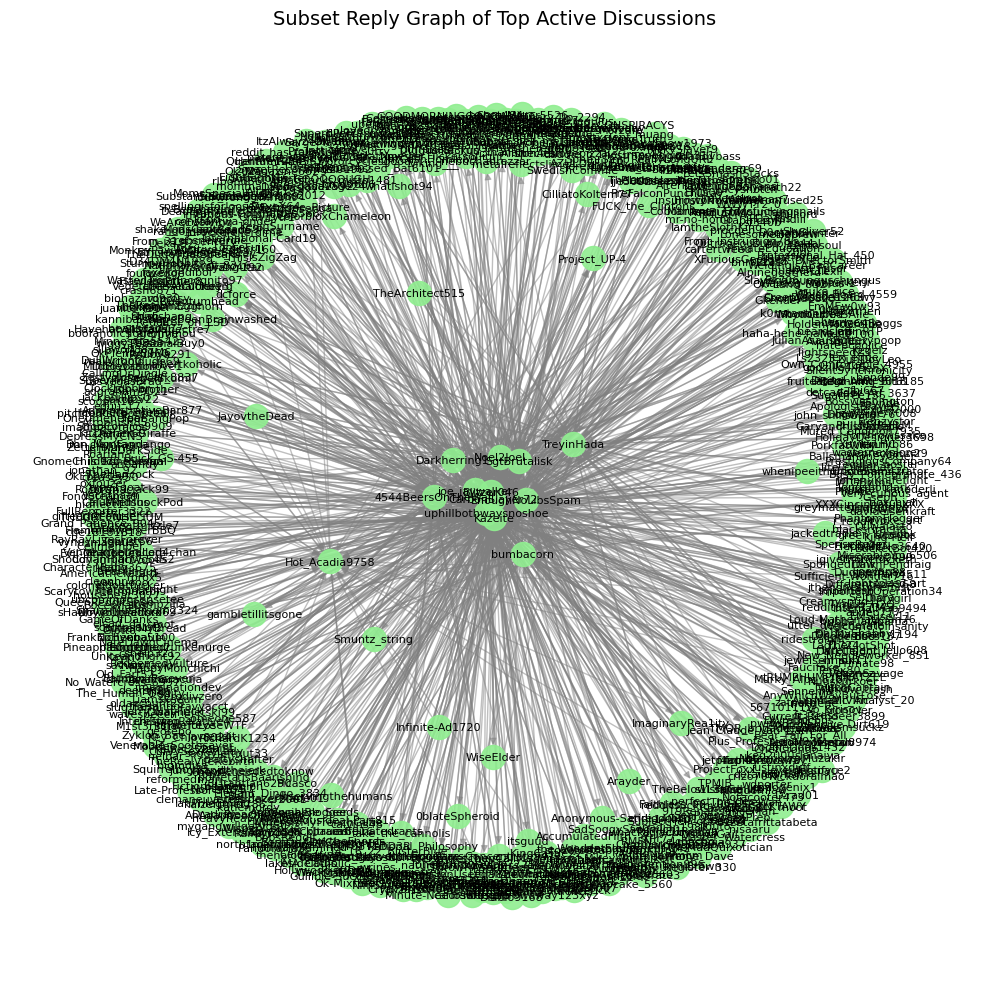

In [36]:
#Get top users by in-degree and out-degree
top_replied_to_users = [user for user, _ in top_replied_to]
top_repliers_users = [user for user, _ in top_repliers]

#Combine both sets (use set to avoid duplicates)
top_users = set(top_replied_to_users + top_repliers_users)

#Filter edges where either node is in the top users
filtered_edges = [(u, v) for u, v in G.edges() if u in top_users or v in top_users]

#Create a subgraph with these edges
G_small = nx.DiGraph()
G_small.add_edges_from(filtered_edges)

#Optionally, keep only nodes connected to others in the filtered set
G_small = G_small.subgraph(set(G_small.nodes)).copy()

#Visualize
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_small, k=0.7, iterations=50, seed=42)

nx.draw_networkx_nodes(G_small, pos, node_size=300, node_color="lightgreen", alpha=0.9)
nx.draw_networkx_edges(G_small, pos, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G_small, pos, font_size=8)

plt.title("Subset Reply Graph of Top Active Discussions", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


### Community Detection

In [37]:
comments = pd.read_csv('reddit_comments.csv',encoding='utf-8')
posts = pd.read_csv('reddit_posts.csv',encoding='utf-8')

In [38]:
Posts = posts[['author', 'cleaned_tokens']]
Comments = comments[['author', 'cleaned_tokens']]

In [39]:
lPosts = pd.concat([Posts, comments], ignore_index=True)

In [40]:
def posts(dataframe_name):
    dataframe_name['cleaned_tokens'] = dataframe_name['cleaned_tokens'].apply(parse_tokens)
    lPosts = dataframe_name[dataframe_name['author'].notna()]
    lPosts = lPosts[~lPosts['author'].isin(['[deleted]', '[removed]'])]
    edges = []
    for _, row in lPosts.iterrows():
        user = row['author']
        tokens = row['cleaned_tokens']
        if not isinstance(tokens, list):
            continue
        for token in tokens:
            edges.append({'user': user, 'keyword': token})
    edges_df = pd.DataFrame(edges)
    min_freq = 5
    keyword_counts = edges_df['keyword'].value_counts()
    edges_df = edges_df[edges_df['keyword'].isin(keyword_counts[keyword_counts >= min_freq].index)]
    edges_df.to_csv("posts_community_user_keyword.csv", index=False)
    return edges_df

In [41]:
def comments(dataframe_name):
    dataframe_name['cleaned_tokens'] = dataframe_name['cleaned_tokens'].apply(parse_tokens)
    lPosts = dataframe_name[dataframe_name['author'].notna()]
    lPosts = lPosts[~lPosts['author'].isin(['[deleted]', '[removed]'])]
    edges = []
    for _, row in lPosts.iterrows():
        user = row['author']
        tokens = row['cleaned_tokens']
        if not isinstance(tokens, list):
            continue
        for token in tokens:
            edges.append({'user': user, 'keyword': token})
    edges_df = pd.DataFrame(edges)
    min_freq = 5
    keyword_counts = edges_df['keyword'].value_counts()
    edges_df = edges_df[edges_df['keyword'].isin(keyword_counts[keyword_counts >= min_freq].index)]
    edges_df.to_csv("comments_community_user_keyword.csv", index=False)
    return edges_df

In [42]:
def parse_tokens(text):
    if isinstance(text, str):
        return text.lower().split()
    return []


In [43]:
posts(Posts)

user         keyword
0       Own_Teacher3433        ['ever',
1       Own_Teacher3433         'land',
2       Own_Teacher3433         'moon']
3             Ms_Photon        ['tell',
4             Ms_Photon        'think',
...                 ...             ...
659587    Mradul_Sharma  'financially',
659588    Mradul_Sharma         'need',
659589    Mradul_Sharma         'good',
659590    Mradul_Sharma    'financial',
659591    Mradul_Sharma         'help']

[628401 rows x 2 columns]

In [44]:
comments(Comments)

user      keyword
0       AutoModerator  ['###meta',
1       AutoModerator    'sticky',
2       AutoModerator   'comment',
3       AutoModerator      'rule',
4       AutoModerator     'apply',
...               ...          ...
456031          Voia-     'voted',
456032          Voia-      'also',
456033          Voia-    'people',
456034          Voia-     'dense']
456035      Sabremesh     ['rule']

[421571 rows x 2 columns]

In [45]:
def community_analysis1(filename,gephi_name):
    edges = pd.read_csv(filename)
    G = nx.from_pandas_edgelist(edges, source='user', target='keyword', create_using=nx.DiGraph)
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected, resolution=1.0)
    communities = set(partition.values())
    print(f"Detected {len(communities)} communities")
    nx.set_node_attributes(G, partition, 'community')
    
    num_communities = len(communities)
    cmap = plt.colormaps['tab20'].resampled(num_communities)
    community_colors = {}
    for i, comm in enumerate(sorted(communities)):
        rgb = cmap(i)[:3]
        hex_color = '#%02x%02x%02x' % tuple(int(255*x) for x in rgb)
        community_colors[comm] = hex_color
    node_colors = {node: community_colors[comm] for node, comm in partition.items()}
    nx.set_node_attributes(G, node_colors, 'color')
    
    community_sizes = pd.Series(partition).value_counts()
    print("Community Sizes:\n", community_sizes)
    community_leaders = {}
    for comm in communities:
        nodes_in_comm = [n for n in G.nodes if partition[n] == comm]
        subgraph = G.subgraph(nodes_in_comm)
        degrees = dict(subgraph.degree())
        leader = max(degrees.items(), key=lambda x: x[1])[0]
        community_leaders[comm] = leader
    print("\nCommunity Leaders:\n", community_leaders)  
    pos = {}
    offset = 10_000
    for i, comm in enumerate(sorted(communities)):
        nodes_in_comm = [n for n in G.nodes if partition[n] == comm]
        subgraph = G.subgraph(nodes_in_comm)
        if len(nodes_in_comm) <= 3:
            sub_pos = nx.random_layout(subgraph)
        else:
            sub_pos = nx.spring_layout(subgraph, seed=42, k=0.5, iterations=100)
        dx, dy = (i * offset, i * offset)
        for node, (x, y) in sub_pos.items():
            pos[node] = (x + dx, y + dy)

    nx.set_node_attributes(G, {k: float(v[0]) for k, v in pos.items()}, 'x')
    nx.set_node_attributes(G, {k: float(v[1]) for k, v in pos.items()}, 'y')

    nx.write_graphml(G, f"{gephi_name}.graphml")


In [46]:
def community_analysis2(filename,gephi_name):
    edges = pd.read_csv(filename)
    G = nx.from_pandas_edgelist(edges, source='user', target='keyword', create_using=nx.DiGraph)
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected, resolution=1.0)
    communities = set(partition.values())
    print(f"Detected {len(communities)} communities")
    nx.set_node_attributes(G, partition, 'community')
    
    num_communities = len(communities)
    cmap = plt.colormaps['tab20'].resampled(num_communities)
    community_colors = {}
    for i, comm in enumerate(sorted(communities)):
        rgb = cmap(i)[:3]
        hex_color = '#%02x%02x%02x' % tuple(int(255*x) for x in rgb)
        community_colors[comm] = hex_color
    node_colors = {node: community_colors[comm] for node, comm in partition.items()}
    nx.set_node_attributes(G, node_colors, 'color')
    
    community_sizes = pd.Series(partition).value_counts()
    print("Community Sizes:\n", community_sizes)
    community_leaders = {}
    for comm in communities:
        nodes_in_comm = [n for n in G.nodes if partition[n] == comm]
        subgraph = G.subgraph(nodes_in_comm)
        degrees = dict(subgraph.degree())
        leader = max(degrees.items(), key=lambda x: x[1])[0]
        community_leaders[comm] = leader
    print("\nCommunity Leaders:\n", community_leaders)
    node_sizes = {node: 10 for node in G.nodes}
    for leader in community_leaders.values():
        if leader in node_sizes:
            node_sizes[leader] = 20
    nx.set_node_attributes(G, node_sizes, 'size')
    pos = {}
    offset = 0
    for comm in communities:
        nodes = [n for n in G.nodes if partition[n] == comm]
        subgraph = G.subgraph(nodes)
        sub_pos = nx.spring_layout(subgraph, seed=42)  
        for n, p in sub_pos.items():
            pos[n] = (p[0] + offset, p[1])  
        offset += 3  

    nx.set_node_attributes(G, {k: float(v[0]) for k, v in pos.items()}, 'x')
    nx.set_node_attributes(G, {k: float(v[1]) for k, v in pos.items()}, 'y')

    nx.write_graphml(G, f"{gephi_name}.graphml")


In [47]:
community_analysis2('posts_community_user_keyword.csv','posts_community_user_keyword')

Detected 10 communities
Community Sizes:
 4    2864
1    2824
3    2439
0    1869
5     746
2     680
8     547
7     473
6     314
9     261
Name: count, dtype: int64

Community Leaders:
 {0: "'moon',", 1: 'qwertycoder', 2: 'Young-Kyoon', 3: 'CuteBananaMuffin', 4: 'CatEyes420', 5: 'trevorj414', 6: 'pokezillaking', 7: 'EnoughNoLibsSpam', 8: 'downvotedcomment_', 9: 'wickster1'}


In [48]:
community_analysis1('comments_community_user_keyword.csv','comments_community_user_keyword')

Detected 17 communities
Community Sizes:
 3     2989
4     2539
2     2246
6     2232
8     1709
5     1639
12    1278
7      173
11      60
14      15
1        9
0        6
13       5
15       4
16       4
9        3
10       3
Name: count, dtype: int64

Community Leaders:
 {0: 'Few-Organization1728', 1: "['enemy',", 2: '4544BeersOnTheWall', 3: "'moon',", 4: "'know',", 5: 'ConspiracyCornerNews', 6: 'Blitzer046', 7: '[]', 8: 'Kazeite', 9: "['exactly']", 10: "['one']", 11: "['space',", 12: 'Serruptitious1', 13: "['link']", 14: 'CommBr', 15: "['alien']", 16: "['national',"}


In [49]:
def extract_keywords_per_community(edges_df, partition):
    edges_df['community'] = edges_df['user'].map(partition)
    keywords_by_comm = edges_df.groupby('community')['keyword'].apply(list)
    
    from collections import Counter
    topics = {}
    for comm, keywords in keywords_by_comm.items():
        counter = Counter(keywords)
        # Top 10 keywords per community
        top_keywords = counter.most_common(10)
        topics[comm] = top_keywords
    return topics

# After running community detection
edges_df = pd.read_csv('posts_community_user_keyword.csv')  # or comments csv
G = nx.from_pandas_edgelist(edges_df, source='user', target='keyword', create_using=nx.DiGraph)
G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected, resolution=1.0)

topics = extract_keywords_per_community(edges_df, partition)
for comm, keywords in topics.items():
    print(f"Community {comm}:")
    print(", ".join([f"{kw}({count})" for kw, count in keywords]))
    print()


Community 0:
'moon',(4637), 'landing',(2818), 'would',(1121), 'people',(1007), 'fake',(854), 'conspiracy',(837), 'hoax',(836), 'space',(794), 'nasa',(782), 'one',(779)

Community 1:
'one',(931), 'god',(693), 'people',(620), 'time',(598), 'year',(569), 'world',(531), 'would',(531), 'also',(514), 'earth',(513), 'like',(498)

Community 2:
'human',(209), 'people',(183), '#xb',(175), 'quantum',(159), 'moon',(157), 'world',(130), 'ancient',(127), 'theory',(126), 'one',(125), 'like',(118)

Community 3:
'nasa',(310), 'space',(236), 'moon',(191), 'earth',(182), 'real',(120), 'control',(112), 'image',(100), 'like',(93), 'world',(93), 'every',(91)

Community 4:
'people',(234), 'even',(201), 'like',(187), 'world',(172), 'would',(130), 'conspiracy',(113), 'one',(110), 'technology',(109), 'thing',(109), 'think',(106)

Community 5:
'earth',(137), 'people',(90), 'moon',(89), 'landing',(73), 'flat',(67), 'harvest',(60), 'know',(57), 'get',(53), 'also',(52), 'emotional',(49)

Community 6:
'moon',(490), 

In [50]:
def extract_keywords_per_community(edges_df, partition):
    edges_df['community'] = edges_df['user'].map(partition)
    keywords_by_comm = edges_df.groupby('community')['keyword'].apply(list)
    
    from collections import Counter
    topics = {}
    for comm, keywords in keywords_by_comm.items():

        clean_keywords = [re.sub(r'[\",\'\[\]]', '', kw).strip() for kw in keywords]
        
        counter = Counter(clean_keywords)
        top_keywords = counter.most_common(10)
        topics[comm] = top_keywords
    return topics


In [51]:
def plot_wordclouds_from_topics(topics):
    import re
    for comm, keywords_counts in topics.items():

        freq_dict = {}
        for kw, count in keywords_counts:
            clean_kw = re.sub(r'[\",\'\[\]]', '', kw).strip()
            freq_dict[clean_kw] = count
        
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Community {comm}")
        plt.show()


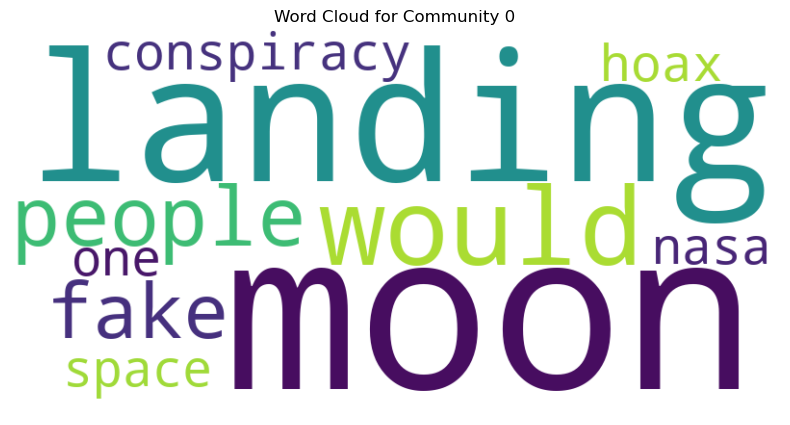

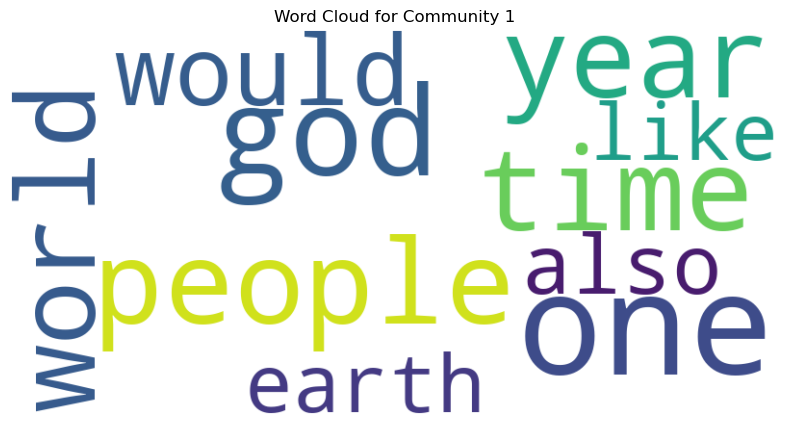

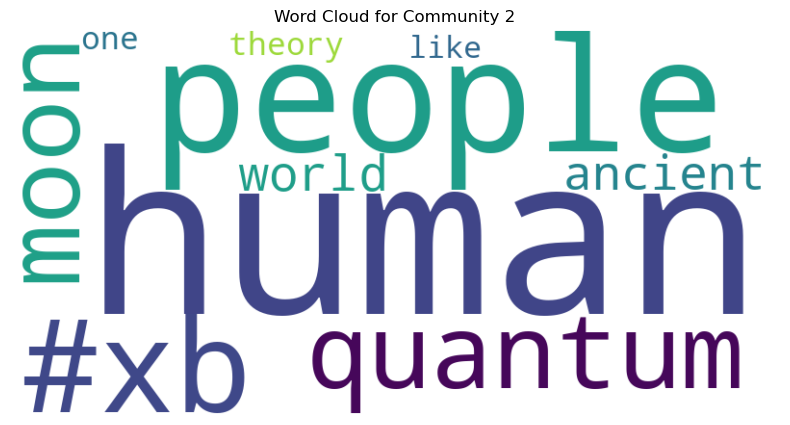

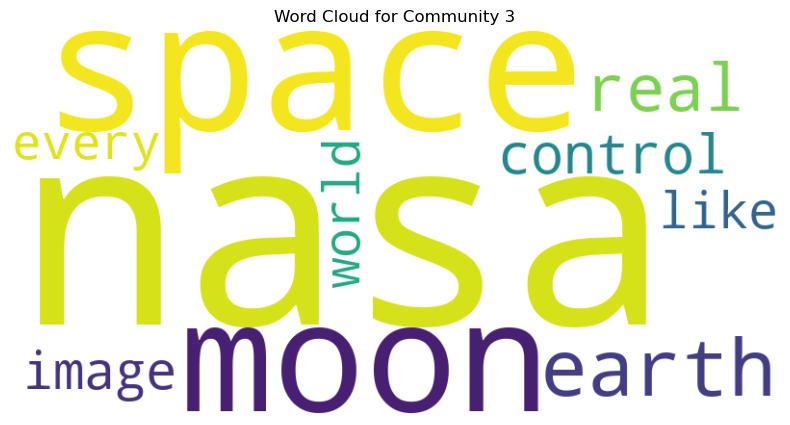

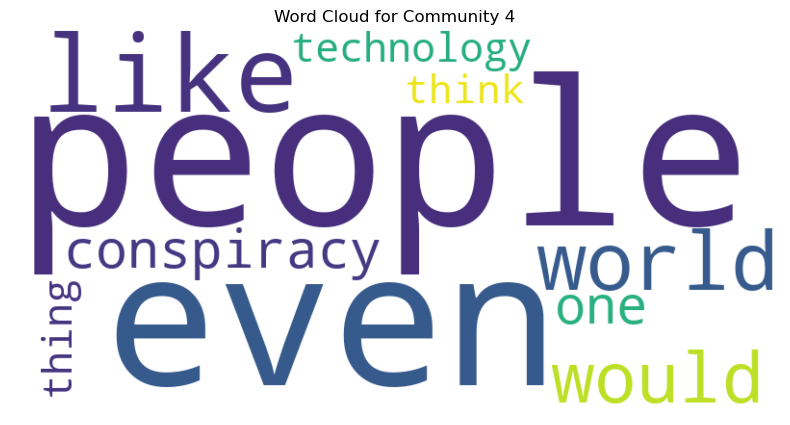

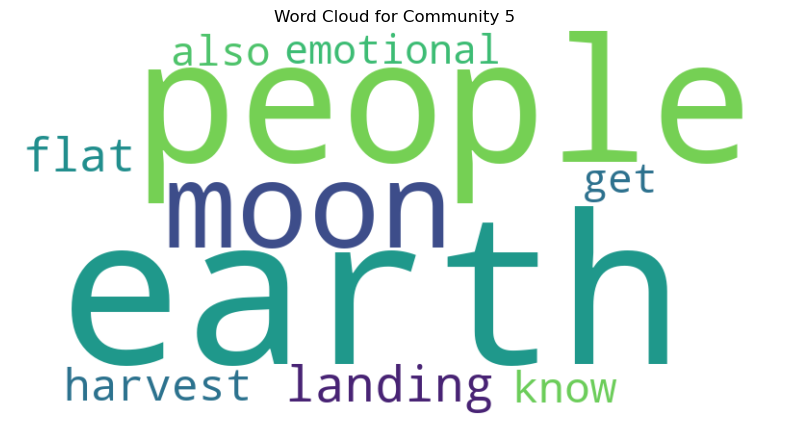

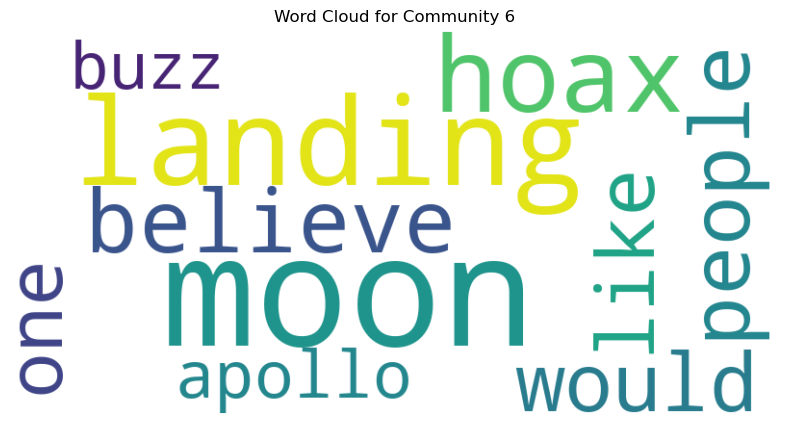

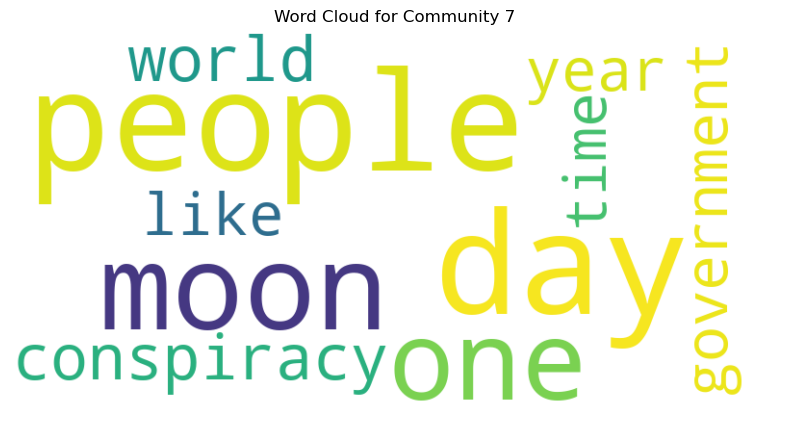

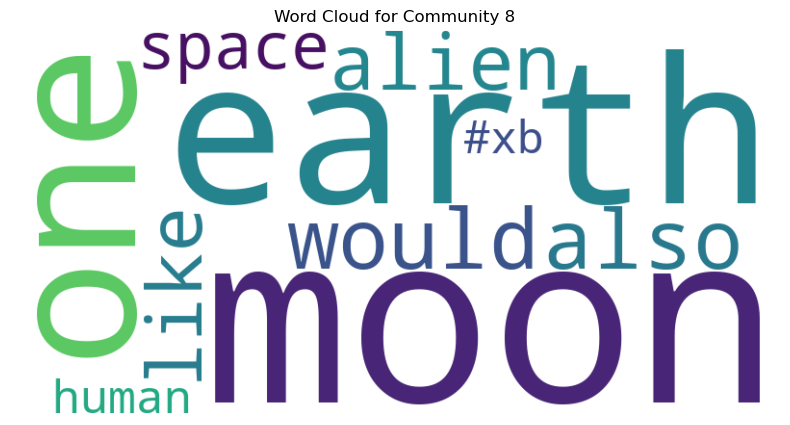

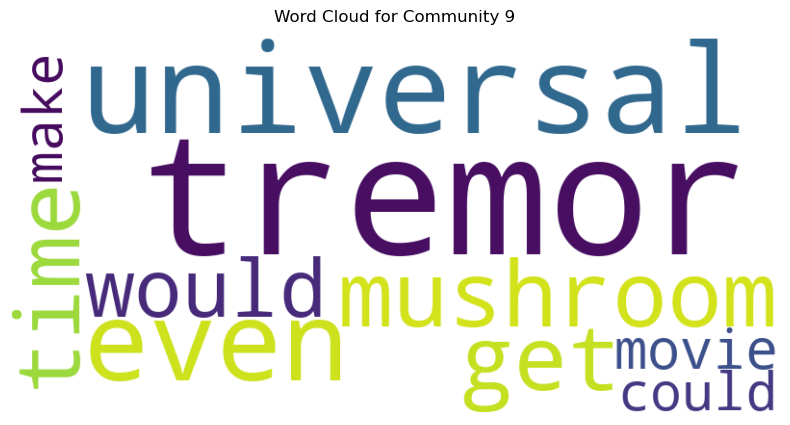

In [52]:
plot_wordclouds_from_topics(topics)